In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

import sys
import numpy as np
from surprise import AlgoBase, Dataset
from surprise.model_selection.validation import cross_validate
import pandas as pd

from scipy.sparse import csr_matrix

import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics.pairwise import cosine_similarity


# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc


from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

schema = StructType([
    StructField("user", IntegerType(), True),
    StructField("movie", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", IntegerType(), True)])

In [26]:
df_ratings = spark.read.csv('../data/ml-latest-small/ratings.csv', sep =',', header=True, schema=schema)
df_ratings = df_ratings.drop('timestamp')

In [48]:
# df = pd.read_csv('../data/ml-latest-small/ratings.csv')
# df = df.drop('timestamp', axis = 1)
# df = df.pivot_table(values='rating', index='userId', columns='movieId')
# df = spark.createDataFrame(df)
df_ratings.min('rating').show()

AttributeError: 'DataFrame' object has no attribute 'min'

In [30]:
print('Number of unique users: {}'.format(df_ratings.select('user').distinct().count()))
print('Number of unique movies: {}'.format(df_ratings.select('movie').distinct().count()))
print('Number of rating: {}'.format(df_ratings.count()))

Number of unique users: 610
Number of unique movies: 9724
Number of rating: 100836


In [31]:
train, test = df_ratings.randomSplit([0.8, 0.2], seed=100)

In [33]:
# user_count = train.groupBy('user').count().toPandas()

# print('Max Ratings: {}'.format(user_count['count'].max()))
# print('Min Ratings: {}'.format(user_count['count'].min()))
# user_count['count'].hist(bins = 100)

In [35]:
# movie_count = train.groupBy('movie').count().toPandas()

# print('Max Ratings: {}'.format(movie_count['count'].max()))
# print('Min Ratings: {}'.format(movie_count['count'].min()))
# movie_count['count'].hist(bins = 100)

Max Ratings: 65
Min Ratings: 1


<AxesSubplot:>

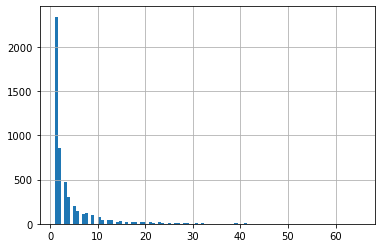

In [71]:
movie_count = test.groupBy('movie').count().toPandas()

print('Max Ratings: {}'.format(movie_count['count'].max()))
print('Min Ratings: {}'.format(movie_count['count'].min()))
movie_count['count'].hist(bins = 100)

In [42]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10,
               )

als = als_model.fit(train)

In [47]:
predictions = als.transform(test)
predictions.describe().show()

+-------+------------------+------------------+------------------+----------+
|summary|              user|             movie|            rating|prediction|
+-------+------------------+------------------+------------------+----------+
|  count|             20119|             20119|             20119|     20119|
|   mean| 326.6528654505691|19502.311894229337|3.5006213032456883|       NaN|
| stddev|182.64528112759464| 35524.37939338994|1.0350441271986937|       NaN|
|    min|                 1|                 1|               0.5|0.23262508|
|    max|               610|            193571|               5.0|       NaN|
+-------+------------------+------------------+------------------+----------+



In [44]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [45]:
evaluator.evaluate(predictions)

nan